In [133]:
# Use GPU
import os
import requests
import json

import pandas as pd
import numpy as np
import torch
import seaborn as sns

from transformers import AutoTokenizer
from transformers import BertTokenizer, BertModel

from tqdm.notebook import tqdm

from IPython.display import display, clear_output
import time  # Just for simulating computation tim

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

from scipy.sparse import hstack

In [112]:
pd.set_option('display.max_rows',None)

In [113]:
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [114]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [115]:
display(df_train.info())
display(df_train.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


### Clean tweet columns

In [116]:
# change target column to something more informative
df_train['target'] = df_train['target'].map({1: True, 0: False})
df_train = df_train.rename(columns={'target': 'Disaster'})

df_test = df_test.rename(columns={'target': 'Disaster'})

df_train = df_train.rename(columns={'text': 'Tweet'})
df_test = df_test.rename(columns={'text': 'Tweet'})

df_train = df_train.rename(columns={'location': 'TweetLocation'})
df_test = df_test.rename(columns={'location': 'TweetLocation'})

df_train = df_train.rename(columns={'keyword': 'TweetKeywords'})
df_test = df_test.rename(columns={'keyword': 'TweetKeywords'})

# drop the id column
df_train = df_train.drop(columns=['id'])

df_train.head(3)

,TweetKeywords,TweetLocation,Tweet,Disaster
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,NaN,NaN,All residents asked to 'shelter in place' are ...,True


In [117]:
display("Missing values")
display(df_train.isna().sum())

'Missing values'

TweetKeywords      61
TweetLocation    2533
Tweet               0
Disaster            0
dtype: int64

**Observation:**
- We can see that locations and keywords are not present for many obvious tweets. Lots of cleaning could fix this.

### Baseline-run
- Before we try in-depth cleaning and processing, lets see what kind of performance we can get using the data alone

In [119]:
vectorizer = CountVectorizer()
X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_tweetkeywords = vectorizer.transform(df_train['TweetKeywords'].fillna("None"))
X_tweetlocation = vectorizer.transform(df_train['TweetLocation'].fillna("None"))
X = hstack([X_tweet, X_tweetkeywords, X_tweetlocation])
y = df_train['Disaster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
print(f"Accuracy Score w/ all features: {accuracy_score(model.predict(X_test),y_test)}")

vectorizer = CountVectorizer()
X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_tweetkeywords = vectorizer.transform(df_train['TweetKeywords'].fillna("None"))
X_tweetlocation = vectorizer.transform(df_train['TweetLocation'].fillna("None"))
X = hstack([X_tweet])
y = df_train['Disaster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
print(f"Accuracy Score w/ just tweets: {accuracy_score(model.predict(X_test),y_test)}")

Accuracy Score w/ all features: 0.8115561391989494
Accuracy Score w/ just tweets: 0.8102429415627052


We see with logistic regression, we get a baseline accuracy of ~81% without any cleaning and only using the tweet column or all features.

### Engineer basic features
- Lets try to engineer some new features

#### Create new feature 'ContainsMention'

In [120]:
df_train['ContainsMention'] = df_train['Tweet'].str.contains('@')
df_test['ContainsMention'] = df_test['Tweet'].str.contains('@')

In [121]:
df_train[df_train['ContainsMention'] == True].sample(2)

,TweetKeywords,TweetLocation,Tweet,Disaster,ContainsMention
3420,explode,"Dallas, TX",@deniseromano @megynkelly @GOP That's one way ...,False,True
955,body%20bag,"sitting on Eddie Vedders lap,",@questergirl ditto but its all we had. and the...,False,True


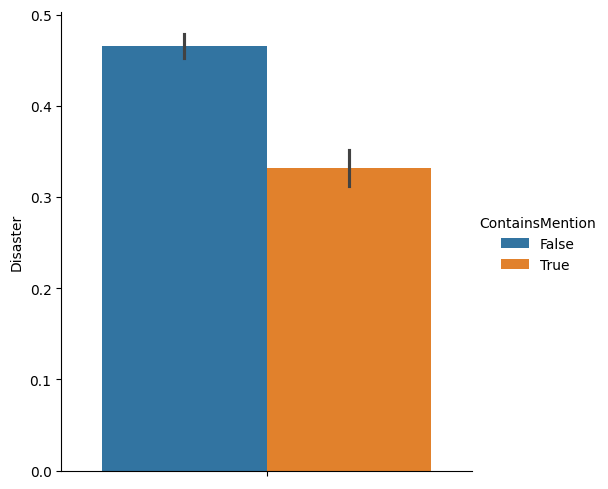

In [122]:
sns.catplot(hue='ContainsMention',y='Disaster',data=df_train,kind='bar')

#### Create new feature 'ContainsUrl'

In [123]:
df_train['ContainsUrl'] = df_train['Tweet'].str.contains(r'http|https|www\.|t\.co', regex=True)
df_test['ContainsUrl'] = df_test['Tweet'].str.contains(r'http|https|www\.|t\.co', regex=True)

In [126]:
df_train[df_train['ContainsUrl'] == True].sample(2)

,TweetKeywords,TweetLocation,Tweet,Disaster,ContainsMention,ContainsUrl
1092,bomb,"Des Moines, IA",E-Hutch is da bomb ?? http://t.co/aqmpxzo3V1,False,False,True
5747,riot,World Wide Web,To All The Meat-Loving Feminists Of The World ...,False,False,True


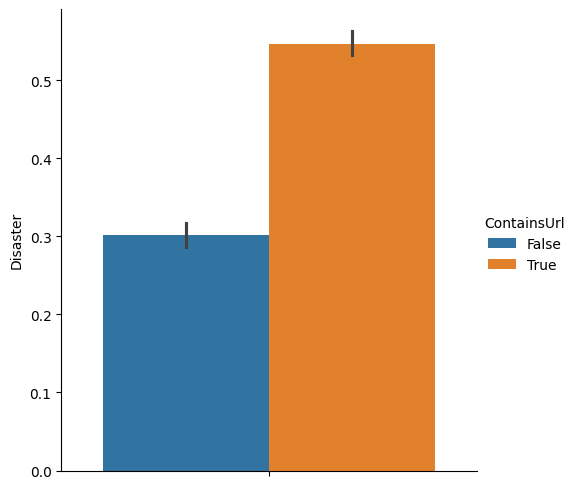

In [127]:
sns.catplot(hue='ContainsUrl',y='Disaster',data=df_train,kind='bar')

In [950]:
# Check to see if we've missed any links
df_train[df_train['ContainsUrl'] == False]['Tweet'].values.tolist()

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

In [7]:
df_train.isna().sum()

TweetKeywords           61
TweetLocation         2533
Tweet                    0
Disaster                 0
ContainsMention          0
ContainsUrl              0
RealTweetLocation     2533
CleanTweetLocation    3660
dtype: int64

### Benchmark model again
- Lets see how the model performs with the new engineered features

In [137]:
vectorizer = CountVectorizer(tokenizer=tweet_tokenizer)

X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_keyword = vectorizer.transform(df_train['TweetKeywords'].fillna('None'))
X_location = vectorizer.transform(df_train['TweetLocation'].fillna('None'))

encoder = OneHotEncoder()
X_onehot = encoder.fit_transform(df_train[['ContainsUrl', 'ContainsMention']])

X = hstack([X_tweet, X_keyword, X_location, X_onehot])
y = df_train['Disaster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and Evaluate
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.799080761654629


The performance is actually worse than before.

We need a better way to capture meaning from text data and a model that can better interpret the information.

Lets finetune BERT.

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [18]:
def get_bert_embeddings(texts: list):
    inputs = tokenizer(texts, return_tensors='pt', max_length=168, padding=True)
    
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate the BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        torch.cuda.empty_cache()
        return embeddings

In [75]:
from itertools import chain


tweets = df_train['Tweet']
num_batches = 10
batches = np.array_split(tweets,num_batches)

from itertools import chain

X = [get_bert_embeddings(batch.values.tolist()) for batch in batches]
X_context_embedding = list(chain.from_iterable(X))
y = df_train['Disaster']

X_train, X_test, y_train, y_test = train_test_split(X_context_embedding, y, test_size=0.2, random_state=42)

# Train Model
mlp_nn = MLPClassifier()
mlp_nn.fit(X_train, y_train)

# Predict and Evaluate
y_pred = mlp_nn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2692: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Accuracy: 0.7721602101116218


/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
vectorizer = CountVectorizer()

X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_keyword = vectorizer.transform(df_train['TweetKeywords'].fillna('None'))

X = hstack([X_tweet, X_keyword])
y = df_train['Disaster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
classifier_tfid = LogisticRegression(max_iter=1000)
classifier_tfid.fit(X_train, y_train)

# Predict and Evaluate
y_pred = classifier_tfid.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8135259356533159


In [35]:
df_train.head()

,TweetKeywords,TweetLocation,Tweet,Disaster,ContainsMention,ContainsUrl,RealTweetLocation,CleanTweetLocation
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True,False,False,NaN,NaN
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,True,False,False,NaN,NaN
2,NaN,NaN,All residents asked to 'shelter in place' are ...,True,False,False,NaN,NaN
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True,False,False,NaN,NaN
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True,False,False,NaN,NaN


In [72]:
vectorizer = CountVectorizer(tokenizer=tweet_tokenizer)

X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_keyword = vectorizer.transform(df_train['TweetKeywords'].fillna('None'))
X_location = vectorizer.transform(df_train['CleanTweetLocation'].fillna('None'))

X = hstack([X_tweet, X_keyword])
y = df_train['Disaster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
mlp_nn = MLPClassifier()
mlp_nn.fit(X_train[:300], y_train[:300])

# Predict and Evaluate
y_pred = mlp_nn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.7097833223900197


In [63]:
tweet_tokenizer("www.hello.com")

['www.hello.com']

In [81]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]
